<a href="https://colab.research.google.com/github/serenabooth/Scaffolding_RL/blob/master/Scaffolding_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Serena Booth

###6.882: Embodied Intelligence

###Spring 2019

This code is modified from: 
https://github.com/ajit2704/Reinforcement-Learning-on-google-colab/blob/master/A3C.ipynb

In [1]:
!apt-get update
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym
!pip install "gym[atari]"
!pip install tqdm
!pip install pyvirtualdisplay
!pip install piglet

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [801 B]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,609 B]
Get:13 http://archive.ubunt

In [2]:
from pyvirtualdisplay import Display
from __future__ import print_function, division
from IPython.core import display
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import gym
from PIL import Image, ImageDraw
from gym.core import Wrapper
from gym.spaces.box import Box
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, Input
from keras.models import Model, Sequential
from tqdm import trange
from google.colab import files
import datetime
import uuid
import pickle
import random

Using TensorFlow backend.


In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

In [0]:
INITIAL_LEARNING_RATE = 1e-3
# The discount factor
GAMMA = 0.99

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [7]:
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c52c8d16.ngrok.io


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
"""Auxilary files for those who wanted to solve breakout with CEM or policy gradient"""


"""
Simplify the game by limiting to only 3 actions (duplicity in Atari environment)
"""
SpaceInvaders_actions = [1, 2, 3] # Fire, Right, Left

class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False, crop=lambda img: img, 
                 n_frames=4, dim_order='theano', reward_scale=1, game_name="SpaceInvaders-v0"):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        assert dim_order in ('theano', 'tensorflow')
        self.img_size = (height, width)
        self.crop=crop
        self.color=color
        self.dim_order = dim_order
        self.reward_scale = reward_scale
        self.num_frames = n_frames
        
        n_channels = (3 * n_frames) if color else n_frames
        obs_shape = [n_channels,height,width] if dim_order == 'theano' else [height,width,n_channels]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')
        
        if game_name == "SpaceInvaders-v0":
            self.action_space = SpaceInvaders_actions
            self.action_size = len(self.action_space)
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer
    
    def step(self,action):
        """plays breakout for 1 step, returns frame buffer"""
        accumulated_reward = 0
        prev_img = None
        new_img = None
        for i in range(0,self.num_frames):
            prev_img = new_img
            new_img, reward, done, info = self.env.step(random.choice(self.action_space))
            accumulated_reward += reward
            if done: 
              break        
            #problem of flickering sprites 
            if prev_img is not None:
              new_img = np.maximum.reduce([new_img, prev_img])
        # only add the 4th frame to the buffer
        # note that this 4th frame takes max pixel values with 3rd frame
        self.update_buffer(new_img)
        return self.framebuffer, accumulated_reward * self.reward_scale, done, info
    
    ### image processing ###
    
    def update_buffer(self,img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'theano':
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        else:
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        #img = imresize(img, self.img_size)
        img = Image.fromarray(img).resize(self.img_size)
        
#         transparent_area = (0,0,42,30)
#         draw=ImageDraw.Draw(img) 
#         draw.rectangle(transparent_area, fill=0)
#         del draw
        
        img = np.array(img)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order == 'theano':
            img = img.transpose([2,0,1]) # [h, w, c] to [c, h, w]
        img = img.astype('float32') / 255.
        return img

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Action space: [1, 2, 3]
Observation shape: (42, 42, 4)
Num actions: 3
Action names: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


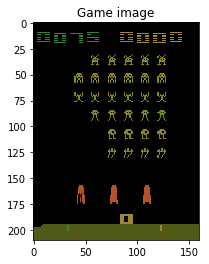

(42, 42, 4)


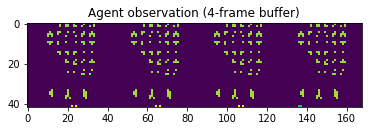

In [201]:
def make_env():
    env = gym.make("SpaceInvaders-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop = lambda img: img[35:-20, :],
                          dim_order = 'tensorflow',
                          color=False, n_frames=4,
                          reward_scale = 0.01)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_size

print ("Action space:", env.action_space)
print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(random.choice(env.action_space))

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
print (s.shape)
plt.imshow(s.transpose([0,2,1]).reshape([42,-1]))
plt.show()

In [116]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            ####
            inputs = Input(shape=state_shape)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(inputs)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu')(x)
            
            # two different output layers
            logits = Dense(n_actions, activation='linear')(x)
            state_value = Dense(1, activation='linear')(x)
            
            self.network = Model(inputs=inputs, outputs=[logits, state_value])
            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
            
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""        
        logits, state_value = self.network(state_t)
        state_value = state_value[:, 0]
        
        assert tf.is_numeric_tensor(state_value) and state_value.shape.ndims == 1, \
            "please return 1D tf tensor of state values [you got %s]" % repr(state_value)
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "please return 2d tf tensor of logits [you got %s]" % repr(logits)
        # hint: if you triggered state_values assert with your shape being [None, 1], 
        # just select [:, 0]-th element of state values as new state values
        
        return (logits, state_value)
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [0]:
agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

In [119]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[-0.00233039  0.00452664 -0.00187805]]
state values:
 [0.00088973]


In [0]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        while True:
            action = agent.sample_actions(agent.step([state]))[0]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards

In [121]:
env_monitor = gym.wrappers.Monitor(env, directory="SI_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

[1.8, 0.9, 1.5000000000000002]


In [122]:
video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./SI_videos/")))
print(video_names)

['openaigym.video.6.129.video000000.mp4', 'openaigym.video.6.129.video000001.mp4']


In [0]:
# files.download('./SI_videos/openaigym.video.0.128.video000001.mp4')

In [0]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [125]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions[:3])
print("Rewards:", batch_rewards[:3])
print("Done:", batch_done[:3])

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


State shape: (10, 42, 42, 4)
Actions: [2 1 1]
Rewards: [0. 0. 0.]
Done: [False False False]


In [0]:
class Summary:
    def __init__(self, logdir, agent, sess):
        with tf.variable_scope('summary'):
            summarising = ['episode_avg_reward', 'entropy']
            self.agent = agent
            self.writer = tf.summary.FileWriter(logdir, sess.graph)
            self.summary_ops = {}
            self.summary_vars = {}
            self.summary_ph = {}
            for s in summarising:
                self.summary_vars[s] = tf.Variable(0.0)
                self.summary_ph[s] = tf.placeholder('float32', name=s)
                self.summary_ops[s] = tf.summary.scalar(s, self.summary_vars[s])
            self.update_ops = []
            for k in self.summary_vars:
                self.update_ops.append(self.summary_vars[k].assign(self.summary_ph[k]))
            self.summary_op = tf.summary.merge(list(self.summary_ops.values()))

    def write_summary(self, summary, t, sess):
        sess.run(self.update_ops, {self.summary_ph[k]: v for k, v in summary.items()})
        summary_to_add = sess.run(self.summary_op, {self.summary_vars[k]: v for k, v in summary.items()})
        self.writer.add_summary(summary_to_add, global_step=t)

In [0]:
# These placeholders mean exactly the same as in "Let's try it out" section above
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [128]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

# compute advantage using rewards_ph, state_values and next_state_values
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

# compute policy entropy given logits_seq. Mind the "-" sign!
entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")

assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "

actor_loss =  - tf.reduce_mean(logp_actions * tf.stop_gradient(advantage)) - 0.001 * tf.reduce_mean(entropy)

# compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph+gamma*next_state_values

critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2 )

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

# Sanity checks to catch some errors. Specific to KungFuMaster in assignment's default setup.
l_act, l_crit, adv, ent = sess.run([actor_loss, critic_loss, advantage, entropy], feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    })

# Add save ability
saver = tf.train.Saver()

# Add summarization 
summary = Summary('./log', agent, sess)


assert abs(l_act) < 100 and abs(l_crit) < 100, "losses seem abnormally large"
assert 0 <= ent.mean() <= np.log(n_actions), "impossible entropy value, double-check the formula pls"
if ent.mean() < np.log(n_actions) / 2: print("Entropy is too low for untrained agent")
print("You just might be fine!")

You just might be fine!


In [129]:
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
# Create a model_id so model can be saved 
model_id = str(datetime.date.today()) + "-" + str(uuid.uuid1())

In [131]:
print (model_id)

2019-05-01-467e491c-6c1a-11e9-9656-0242ac1c0002


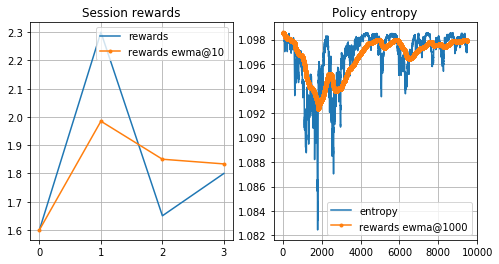





 95%|█████████▌| 9502/10000 [06:25<00:46, 10.79it/s]



 95%|█████████▌| 9505/10000 [06:26<00:38, 13.02it/s]



 95%|█████████▌| 9508/10000 [06:26<00:31, 15.44it/s]



 95%|█████████▌| 9511/10000 [06:26<00:27, 17.70it/s]



 95%|█████████▌| 9514/10000 [06:26<00:24, 19.81it/s]



 95%|█████████▌| 9517/10000 [06:26<00:22, 21.69it/s]



 95%|█████████▌| 9520/10000 [06:26<00:20, 23.22it/s]



 95%|█████████▌| 9523/10000 [06:26<00:19, 24.20it/s]



 95%|█████████▌| 9526/10000 [06:26<00:19, 24.92it/s]



 95%|█████████▌| 9529/10000 [06:26<00:18, 25.08it/s]



 95%|█████████▌| 9532/10000 [06:27<00:18, 25.62it/s]



 95%|█████████▌| 9535/10000 [06:27<00:17, 26.15it/s]



 95%|█████████▌| 9538/10000 [06:27<00:17, 26.24it/s]



 95%|█████████▌| 9541/10000 [06:27<00:17, 26.51it/s]



 95%|█████████▌| 9544/10000 [06:27<00:17, 26.04it/s]



 95%|█████████▌| 9547/10000 [06:27<00:17, 26.34it/s]



 96%|█████████▌| 9550/10000 [06:27<00:17, 26.46it/s]



 96%|█████████▌| 9553/10000 [06:27<00:16, 26

In [132]:
for i in trange(10000): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    batch_states = batch_next_states
    
    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.max(evaluate(agent, env, n_games=3)))
            summary.write_summary({'episode_avg_reward': rewards_history[-1], 'entropy': entropy_history[-1]}, i, sess)

            if rewards_history[-1] >= 50:
                print("Your agent has earned the yellow belt")

        path = F"/content/gdrive/My Drive/RL_models/" + model_id
        save_path = saver.save(sess, path + ".ckpt")

    
        pickle.dump( rewards_history , open( path + "_rewards", "wb" ) )
        pickle.dump( entropy_history , open( path + "_entropy", "wb" ) )

        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(pd.DataFrame(np.array(rewards_history)).ewm(span=10).mean(), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(pd.DataFrame(np.array(entropy_history)).ewm(span=1000).mean(), marker='.', label='rewards ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()

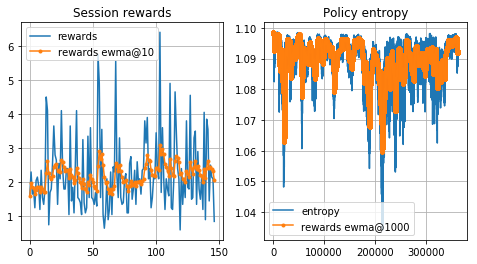





 56%|█████▌    | 55503/100000 [42:53<5:23:40,  2.29it/s]



 56%|█████▌    | 55506/100000 [42:53<3:55:16,  3.15it/s]



 56%|█████▌    | 55509/100000 [42:53<2:53:31,  4.27it/s]



 56%|█████▌    | 55512/100000 [42:53<2:09:30,  5.73it/s]



 56%|█████▌    | 55515/100000 [42:54<1:38:50,  7.50it/s]



 56%|█████▌    | 55518/100000 [42:54<1:17:06,  9.62it/s]



 56%|█████▌    | 55521/100000 [42:54<1:01:53, 11.98it/s]



 56%|█████▌    | 55524/100000 [42:54<51:28, 14.40it/s]  



 56%|█████▌    | 55527/100000 [42:54<43:42, 16.96it/s]



 56%|█████▌    | 55530/100000 [42:54<38:40, 19.16it/s]



 56%|█████▌    | 55533/100000 [42:54<35:31, 20.87it/s]



 56%|█████▌    | 55536/100000 [42:54<33:31, 22.11it/s]



 56%|█████▌    | 55539/100000 [42:54<31:56, 23.20it/s]



 56%|█████▌    | 55542/100000 [42:55<30:09, 24.57it/s]



 56%|█████▌    | 55545/100000 [42:55<29:29, 25.13it/s]



 56%|█████▌    | 55548/100000 [42:55<28:51, 25.67it/s]



 56%|█████▌    | 55551/100000 [42:55<28:04, 26.39it/

KeyboardInterrupt: ignored

In [136]:
# load existing model and continue training it. You may need to rerun the Agent initialization code. 

env_batch = EnvBatch(10)
batch_states = env_batch.reset()
model_id = "2019-05-01-467e491c-6c1a-11e9-9656-0242ac1c0002"

with tf.Session() as sess:
  # Restore variables from disk.
  path = F"/content/gdrive/My Drive/RL_models/" + model_id
  saver.restore(sess, path + ".ckpt")
  print("Model restored.")
  
  rewards_history = pickle.load( open( path + "_rewards", "rb" ) )
  entropy_history = pickle.load( open( path + "_entropy", "rb" ) )

  for i in trange(100000): 
    
    batch_actions = agent.sample_actions(agent.step(batch_states))
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)
    
    feed_dict = {
        states_ph: batch_states,
        actions_ph: batch_actions,
        next_states_ph: batch_next_states,
        rewards_ph: batch_rewards,
        is_done_ph: batch_done,
    }
    batch_states = batch_next_states
    
    _, ent_t = sess.run([train_step, entropy], feed_dict)
    entropy_history.append(np.mean(ent_t))

    if i % 500 == 0: 
        if i % 2500 == 0:
            rewards_history.append(np.max(evaluate(agent, env, n_games=3)))
            summary.write_summary({'episode_avg_reward': rewards_history[-1], 'entropy': entropy_history[-1]}, i, sess)
#             if rewards_history[-1] >= 50:
#                 print("Your agent has earned the yellow belt")

        path = F"/content/gdrive/My Drive/RL_models/" + model_id
        save_path = saver.save(sess, path + ".ckpt")
    
        pickle.dump( rewards_history , open( path + "_rewards", "wb" ) )
        pickle.dump( entropy_history , open( path + "_entropy", "wb" ) )

        clear_output(True)
        plt.figure(figsize=[8,4])
        plt.subplot(1,2,1)
        plt.plot(rewards_history, label='rewards')
        plt.plot(pd.DataFrame(np.array(rewards_history)).ewm(span=10).mean(), marker='.', label='rewards ewma@10')
        plt.title("Session rewards"); plt.grid(); plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(entropy_history, label='entropy')
        plt.plot(pd.DataFrame(np.array(entropy_history)).ewm(span=1000).mean(), marker='.', label='rewards ewma@1000')
        plt.title("Policy entropy"); plt.grid(); plt.legend()        
        plt.show()

In [81]:
env_monitor = gym.wrappers.Monitor(env, directory="SI_videos", video_callable=lambda episode_id: True, force=True)
final_rewards = evaluate(agent, env_monitor, n_games=10,)
env_monitor.close()
print (final_rewards)
print("Final mean reward:", np.mean(final_rewards))

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./SI_videos/")))
print(video_names)


  5%|▍         | 4757/100000 [04:03<1:10:19, 22.57it/s]

[0.9500000000000001, 0.5, 0.25, 0.8, 1.5, 2.1, 1.8, 1.55, 1.2000000000000002, 0.45000000000000007]
Final mean reward: 1.1099999999999999
['openaigym.video.4.129.video000002.mp4', 'openaigym.video.4.129.video000003.mp4', 'openaigym.video.4.129.video000008.mp4', 'openaigym.video.4.129.video000000.mp4', 'openaigym.video.4.129.video000005.mp4', 'openaigym.video.4.129.video000004.mp4', 'openaigym.video.4.129.video000009.mp4', 'openaigym.video.4.129.video000006.mp4', 'openaigym.video.4.129.video000001.mp4', 'openaigym.video.4.129.video000007.mp4']


In [0]:
files.download('./SI_videos/openaigym.video.4.129.video000007.mp4')